### Generate time series from given PSD

Example script to generate a sequence of phase errors (to apply in the simulations) by taking the inverse discrete Fourier transform of the square root of the power spectral density (created by Andy).


2) Compute the PSD of the signal, $\rm PSD(f(k))$

3) Before applying the iDFT:

a) Convert the noise power to FFT amplitue, $A(f(k))= \sqrt{(PSD(f(k))}$

b) Give each spectral component a random phase, uniformly distributed between 0 and the frange, $\rm Phi(f(k))$

c) Construct a frequency domain signal $\rm Z(f(k)) = A(f(k)) \cdot e^{i  Phi(f(k))}$. This is the FFT of the noise spectrum

- Note that this signal contains only the positive-frequency terms,  f(k) > 0 (one-sided).
- However, the fft as returned from the numpy functions include also the negative-frequency terms. Specifically it is ordered as follows:
        - a[0] contains the zero frequency terms

        - a[1:n//2] contains the positive-frequency terms,

        - a[n//2 + 1:] contains the negative-frequency terms, in increasing order starting from the most negative frequency.
- In order to bring the signal $\rm Z(f(k))$ at this form, we:

    a)  Create a list with the complex conjugates of all but the first elements of the frequency signal, the first element is set later to zero
    
    b)  We reverse the order of the list and merge it with the initial signal
    
    c)  Set the first element to zero
    
 4) Apply the iDFT. 
 
 
 The output of the iDFT will be a random time series on the finite (bounded, limited) time interval t = 0 to tmax = (N-1) X Dt, where Dt = 1 / (frange).

 The noise signal (time series), variable $y2$, is the real part of the result. 
 

Note: This script can run with a known sinusoidal signal and with a white noise signal.

In [54]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Create the signal (time series).

Option A: sinusoidal signal with frequency at 40 Hz


Option B: White noise. In the case of the white noise if you want better result on the PSD computation you need to average over 1000 runs. See at ../PSD_computation/job001...

In [74]:
# Option A
f = 40.
t = np.linspace(0, 0.5, 1000) # larger number of points will result to have the frequency exactly on a bin
# when you create later on the angles randomly, there are more chances that you actually represent the initial spectrum
y = 2* np.sin(2*np.pi*f*t) 

# Option B
mu, stdPhaseNoise = 0, 1e-8
y = np.random.normal(mu, stdPhaseNoise, 1000)

Text(0, 0.5, 'ampltidue (a.u.)')

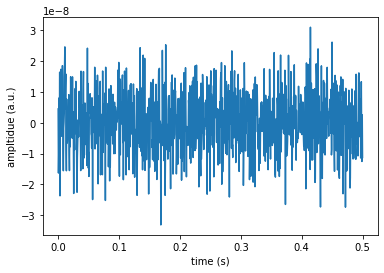

In [75]:
plt.plot(t, y)
plt.xlabel('time (s)')
plt.ylabel('ampltidue (a.u.)')

### 2. Perform FFT, DFT --> not normalised with sqrt(1/N)

In [76]:
N = y.size
Dt = t[1]-t[0] # sampling
fft = np.fft.fft(y)
freq = np.fft.fftfreq(N, Dt )
Df = freq[1]-freq[0]

Text(0, 0.5, 'Amplitude (a.u.)')

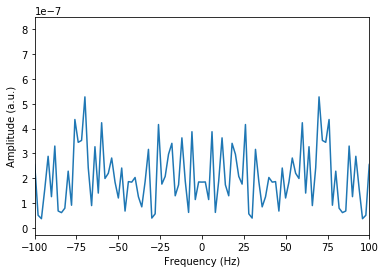

In [77]:
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(np.abs(fft)))
plt.xlim(-100, 100)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (a.u.)')

### 3. Compute the PSD, keep only the positive part of the spectrum

In [78]:
fft_pos = fft[:N//2]
freq_pos = freq[:N//2]
psd = np.abs(fft_pos)**2/((N**2)*Df)

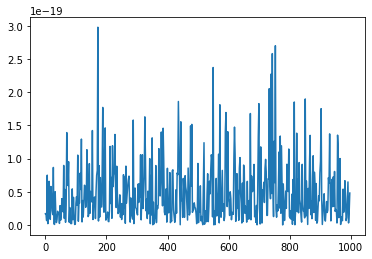

In [79]:
plt.plot(freq_pos, psd)

### 4. Go back to the time series

In [80]:
# a. convert the noise power to fft amplitude
A = np.sqrt(psd*(N**2)*Df)

In [81]:
# Give each spectral component a random phase, uniformly distributed between 0 and
# the maximum frequency,  Phi(f(k))
phi = np.exp(1j*2*np.pi*np.random.uniform(0,1,len(freq_pos)))

In [82]:
# Construct a frequency domain signal Z(f(k)) = A(f(k)) X e^(i X PHI(f(k))), this is the FFT of the noise spectrum
fft_y2 = A*phi

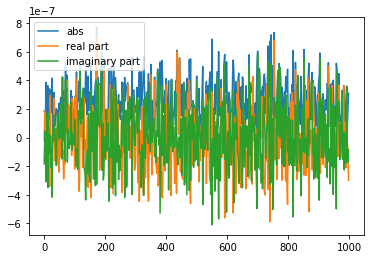

In [83]:
plt.plot(freq_pos, np.abs(fft_y2), label='abs')
plt.plot(freq_pos, fft_y2.real, label='real part')
plt.plot(freq_pos, fft_y2.imag, label='imaginary part')
plt.legend()

In [84]:
# complex conjugate of all but the first element
y2fft_conj = np.conj(fft_y2[1:])
# Reverse the list
reversed_list = y2fft_conj[::-1]
# merge them
merged_list = list(fft_y2) + list(reversed_list)
merged_list[0] = 0

In [85]:
# As close as we can get to the real signal
y2 = np.real(np.fft.ifft(merged_list)) 

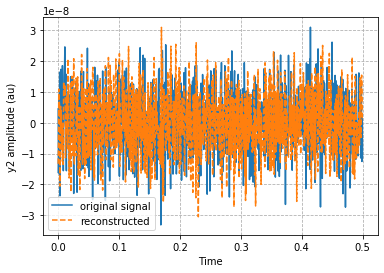

In [86]:
plt.plot(t, y, label='original signal')
plt.plot(t[:-1], y2, label='reconstructed', linestyle='dashed')
plt.legend()
plt.xlabel('Time')
plt.ylabel('y2 amplitude (au)')
plt.grid(True, linestyle='--')